In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.6 MB/s eta 0:00:00


In [4]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import feature_extraction, feature_selection
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics

from collections import Counter
from spellchecker import SpellChecker

sns.set(rc={'figure.figsize':(15, 7)})

In [5]:
data = pd.read_csv('/content/drive/MyDrive/automl/train.csv')

# Проверка на отсутсвующие значения и дубликаты

In [6]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [7]:
data.shape

(36765, 5)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


Пропущенных значений нет

In [9]:
data.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


Проверим наличие дубликатов

In [10]:
duplicates = data[data.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")
duplicates

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
...,...,...,...,...,...
27033,f6b2d34d9c01,A98E8EFFC8A9,the technology failing,Claim,Adequate
35488,bcdb6e47ede3,AB8EFBD82820,you can help others.,Claim,Ineffective
35493,98510222f9b8,AB8EFBD82820,you can help others.,Claim,Adequate
4788,d068e2c646e8,56C6D97AF40B,you get to see the world,Claim,Adequate


In [11]:
duplicates.shape

(119, 5)

In [12]:
# filtered_df = duplicates.drop_duplicates(subset='discourse_text', keep='last')
# filtered_df.shape –> (45,5)

Дубликаты появляются за счет того, что некоторые фразы встречаются в разных эссе. Эти фразы также могут быть классифицированы по-разному в зависимости от контекста всего эссе. Средний размер эссе 4000 слов, что добольно много, поэтому принято решение работать только с имеющимися в таблице данными. Т.к. таких дубликатов не много (119 из 36765), они будут отброшены таким образом, что будет оставаться только последнее вхождение (для сохранения класса 'Ineffective', т.к. дубликатов с ним больше, чем 'Effective', и в общем распределении 'Ineffective' самый маленький класс).

In [13]:
data = data.drop_duplicates(subset='discourse_text', keep='last')

In [14]:
data.shape

(36691, 5)

In [15]:
data.to_csv('train_new.csv')

# Распределение классов

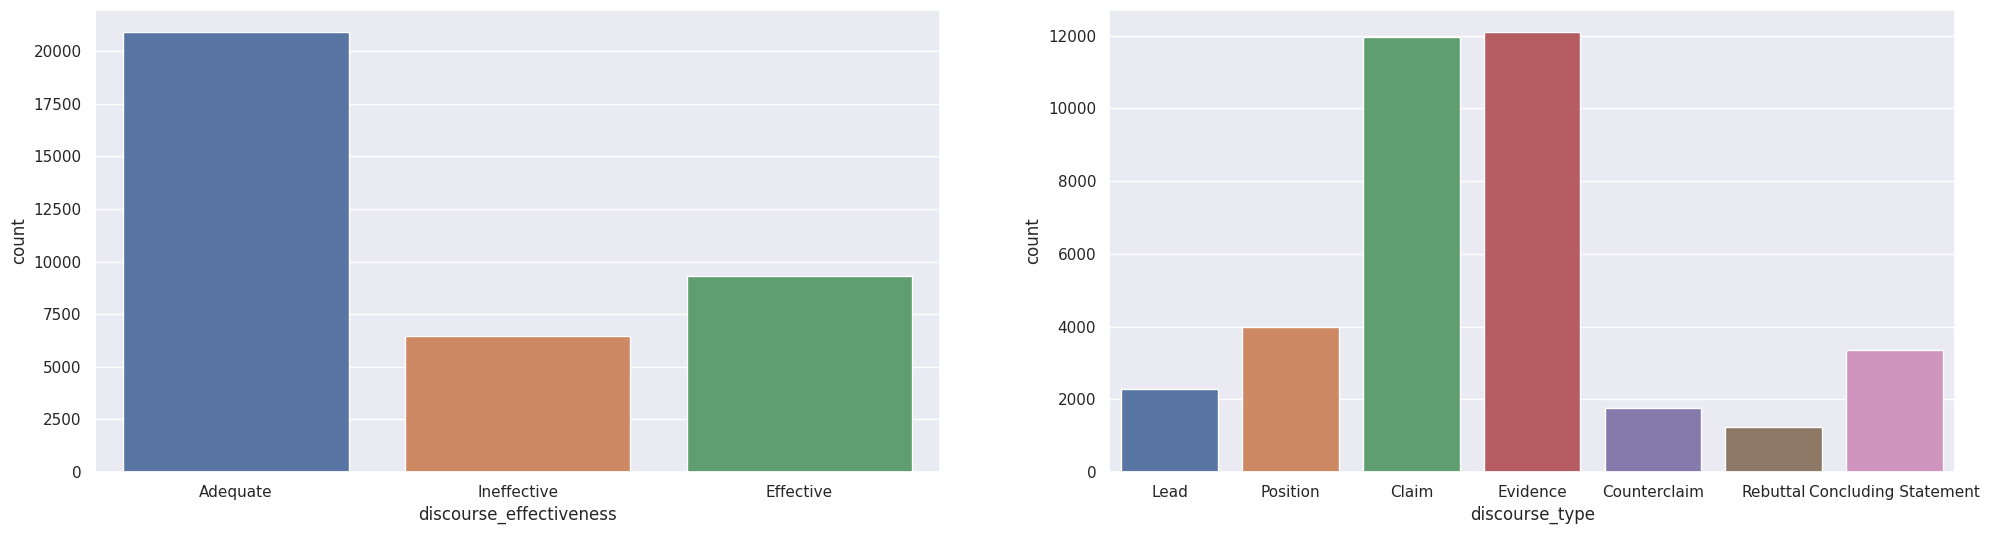

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
sns.countplot(data = data, x = "discourse_effectiveness", ax = ax[0])
sns.countplot(data = data, x = "discourse_type", ax = ax[1])
plt.show()

Классы несбалансированы, преобладает класс "Adequate". Можно попробовать создать сбалансированную выборку для обучения.

 Типы дискурсов 'Evidence' и 'Claim', являются более распространенными, поэтому их результатам следует отдавать приоритет.

In [16]:
sampled_df = data.groupby('discourse_effectiveness', group_keys=False).apply(lambda x: x.sample(min(len(x), 3000)))
sampled_df.shape

(9000, 5)

In [17]:
sampled_df.to_csv('train_balanced.csv')

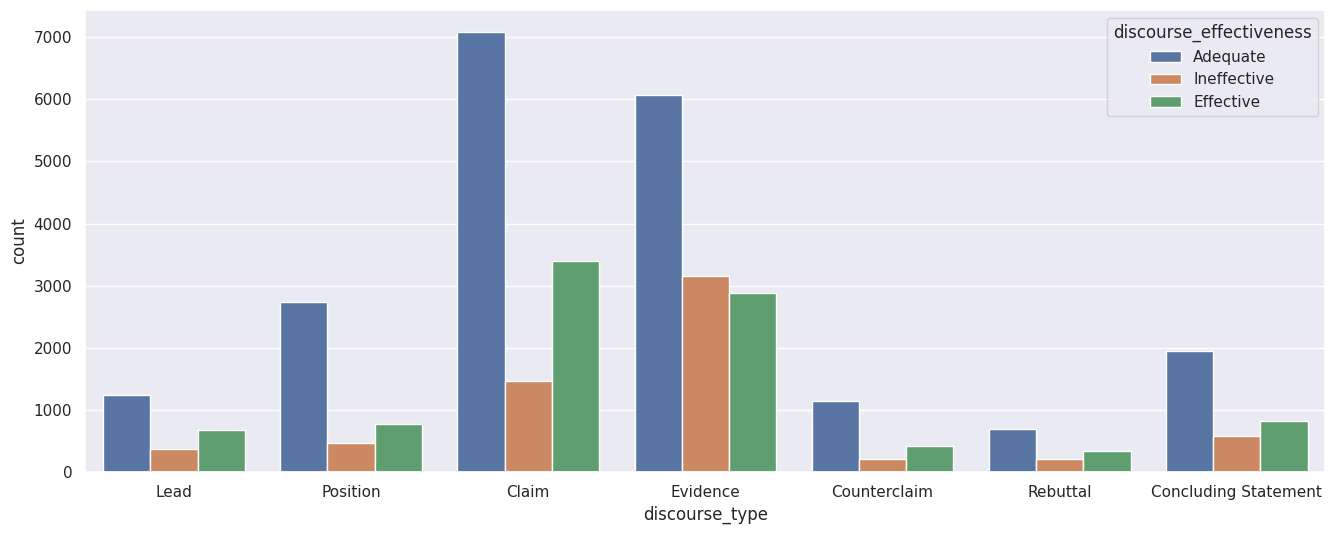

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
sns.countplot(data = data, x = 'discourse_type', hue='discourse_effectiveness')
plt.show()

Распределение классов по типам дискурсов похоже, за исключением дискурсов типа "Evidence", где класс "Ineffective" преобладает над классом "Effective" в отличие от остальных типов.

<Axes: >

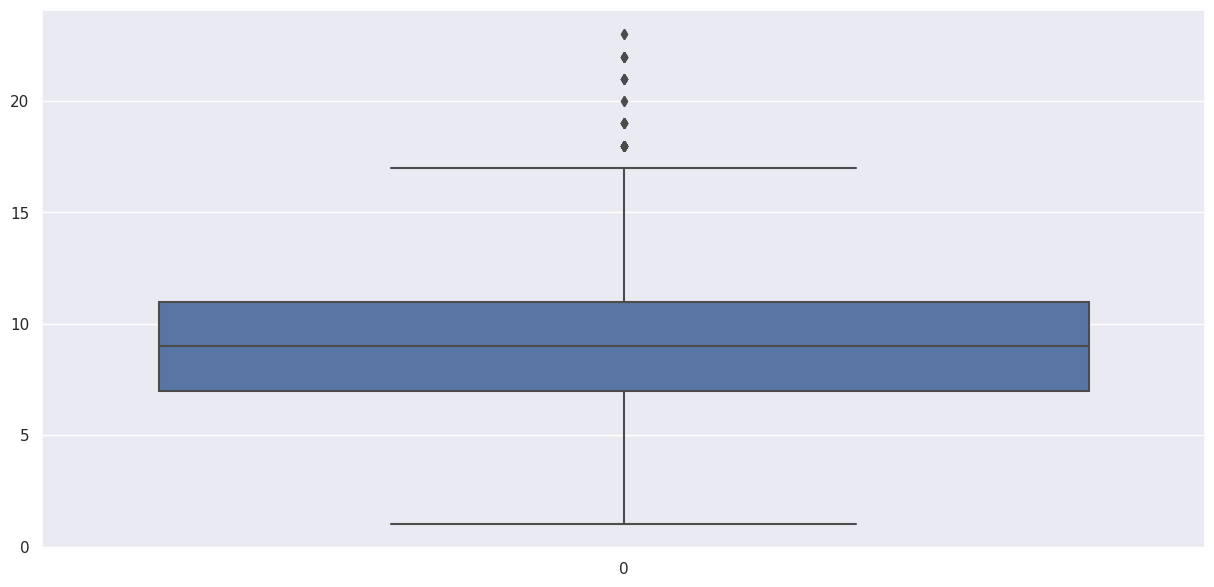

In [ ]:
disc_amount = data.groupby(["essay_id"]).discourse_type.value_counts().to_frame()
disc_amount.columns = ['amount']
disc_amount.reset_index(drop = False, inplace=True)
disc_amount = disc_amount.pivot(index="essay_id", columns = "discourse_type").amount

sns.boxplot(disc_amount.fillna(0).sum(axis=1))

В среднем из каждого эссе выделяются 8-9 'discourse_text'.

In [ ]:
disc_amount.mean()

discourse_type
Claim                   3.167417
Concluding Statement    1.005702
Counterclaim            1.312083
Evidence                2.904728
Lead                    1.000875
Position                1.004800
Rebuttal                1.223206
dtype: float64

# Features Engineering

Можно предположить, что тексты с большей общей длиной, большей средней длиной слов и большим количеством слов должны быть более "эффективными". Также на эффективность/неэффективность может влиять наличие ошибок в тексте.

In [ ]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


## Посимвольная длина текста

<Axes: ylabel='Frequency'>

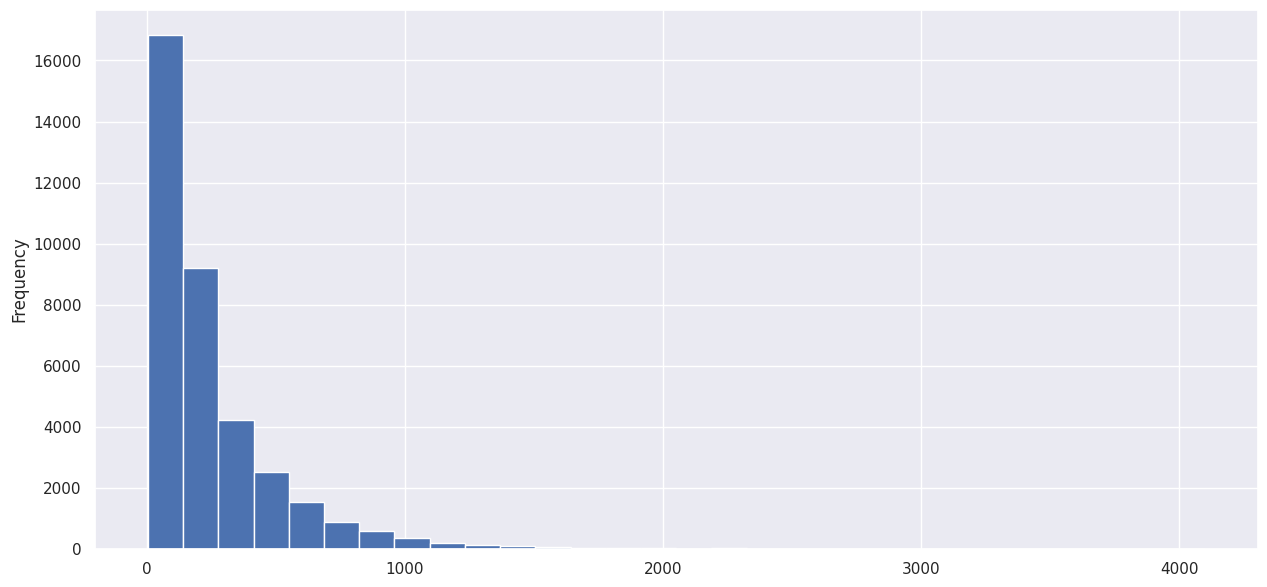

In [ ]:
fig = plt.figure(figsize=(15, 7))
data['char_length'] = data['discourse_text'].apply(lambda x: len(x))
data['char_length'].plot.hist(bins=30)

(0.0, 800.0)

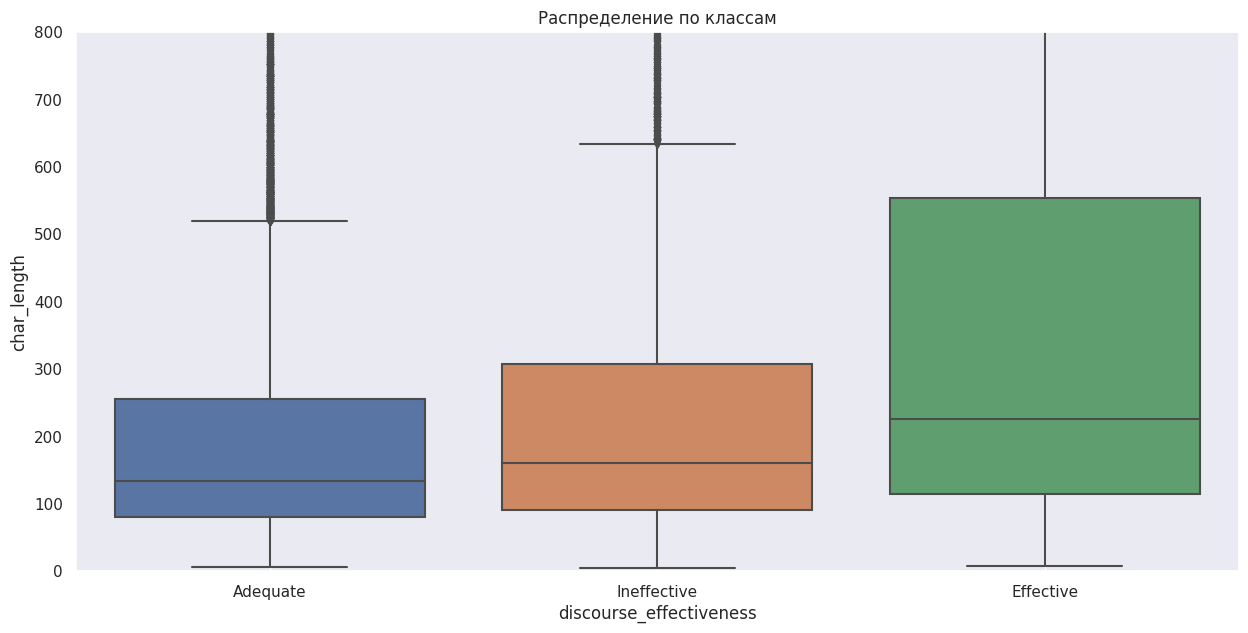

In [ ]:
fig = plt.figure(figsize=(15, 7))
sns.boxplot(x="discourse_effectiveness", y="char_length", data=data)
plt.title('Распределение по классам')
plt.grid()
plt.ylim(0, 800)

Общая средняя длина текстов класса 'Effective' больше, чем 'Adequate' и 'Ineffective'.

## Количество слов в тексте

<Axes: ylabel='Frequency'>

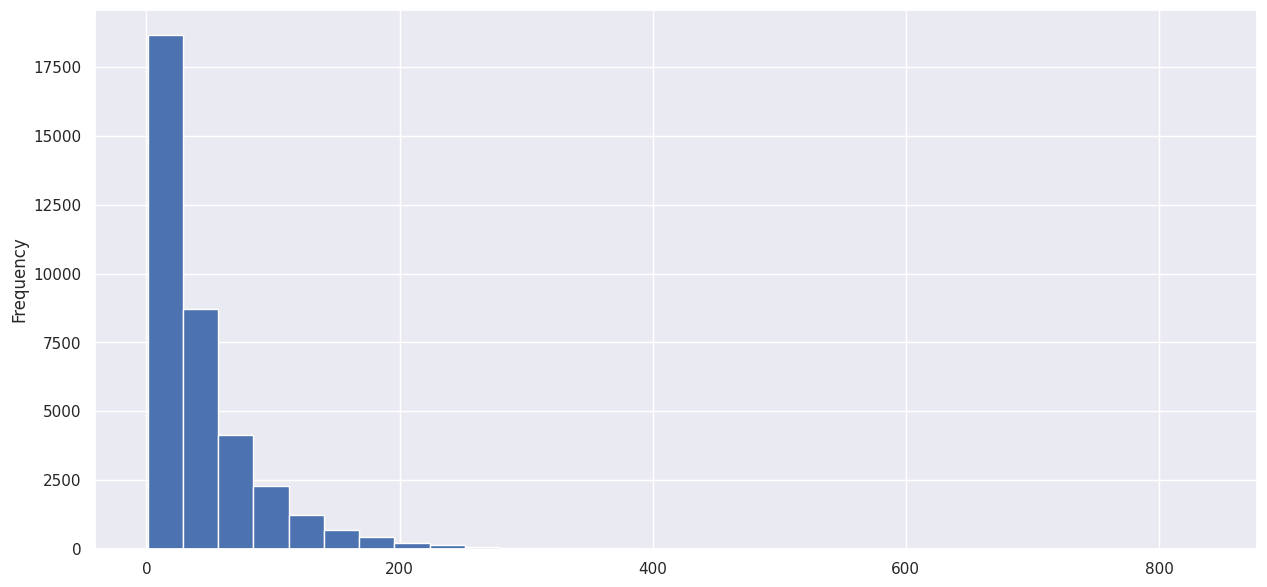

In [ ]:
fig = plt.figure(figsize=(15, 7))
data['word_count'] = data['discourse_text'].apply(lambda x: len(x.split()))
data['word_count'].plot.hist(bins=30)

(0.0, 225.0)

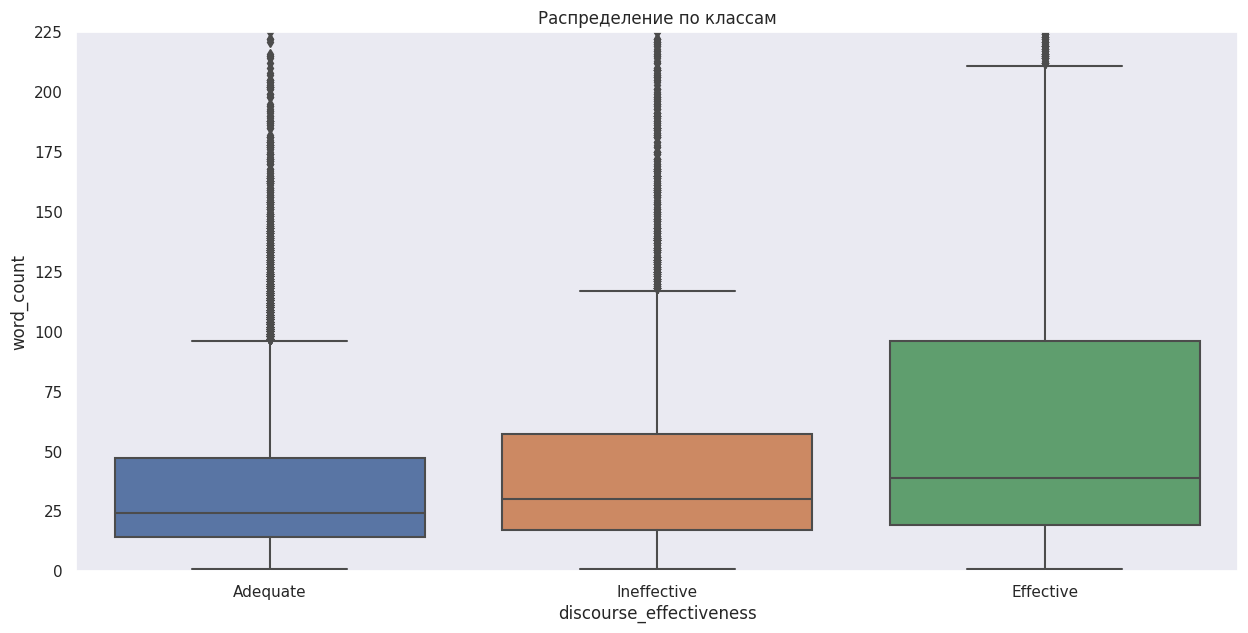

In [ ]:
fig = plt.figure(figsize=(15, 7))
sns.boxplot(x="discourse_effectiveness", y="word_count", data=data)
plt.title('Распределение по классам')
plt.grid()
plt.ylim(0, 225)

Распределение схожее с char_length.

## Средняя длина слов

<Axes: ylabel='Frequency'>

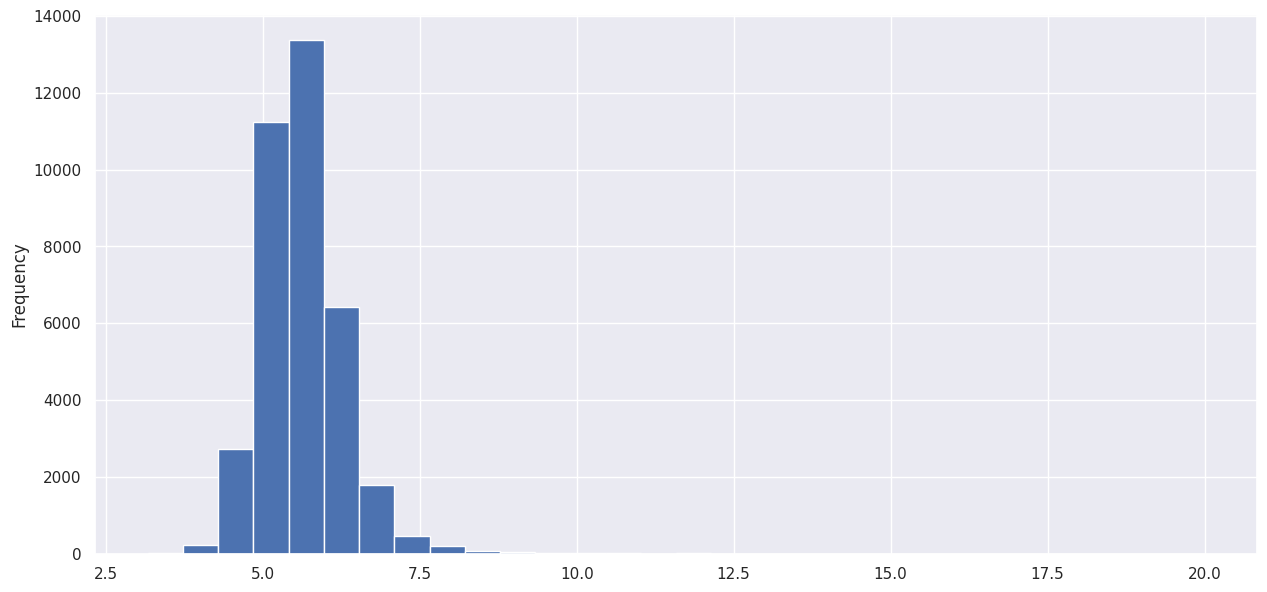

In [ ]:
fig = plt.figure(figsize=(15, 7))
data['avg_word_length'] = data['char_length'] / data['word_count']
data['avg_word_length'].plot.hist(bins=30)

(3.0, 8.0)

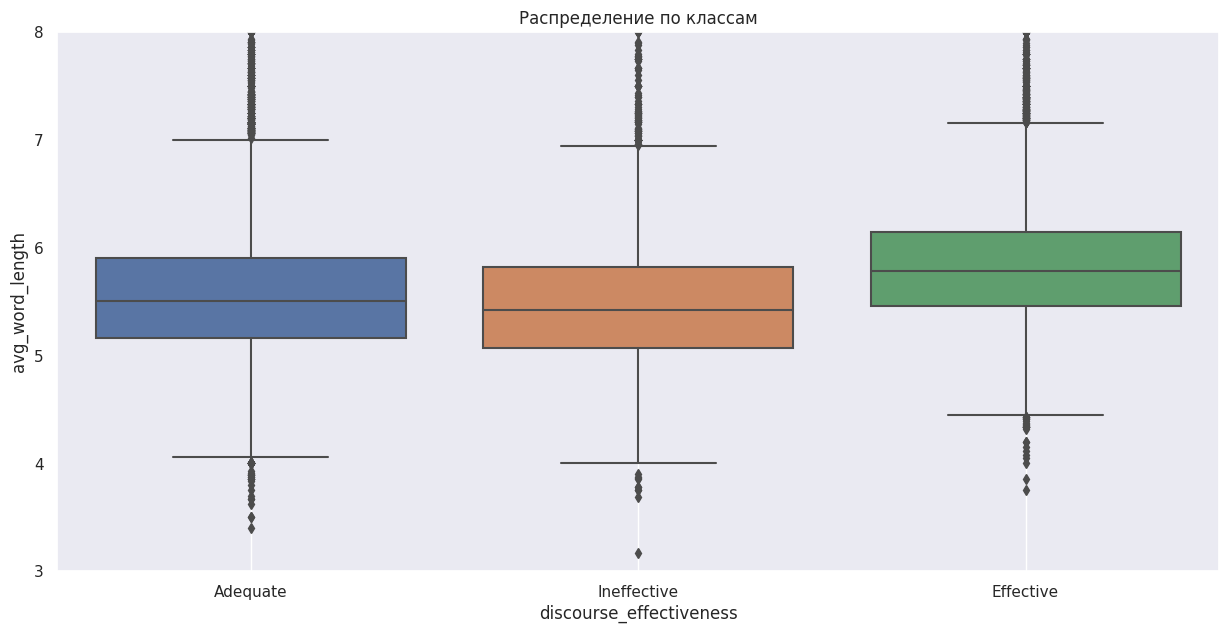

In [ ]:
fig = plt.figure(figsize=(15, 7))
sns.boxplot(x="discourse_effectiveness", y="avg_word_length", data=data)
plt.title('Распределение по классам')
plt.grid()
plt.ylim(3, 8)

Средняя длина слов класса 'Effective' больше, чем 'Adequate' и 'Ineffective'.

## Ошибки в тексте

In [ ]:
spell = SpellChecker(distance=1)
custom_words = ['dont', 'shouldnt', 'doesnt', 'didnt', 'isnt', 'theyre', 'youre', 'wasnt', 'b', 'c', 'f', 's', '3d','landform', 'cydonia', 'nondemocratic', 'dr', 'thier']
for word in custom_words:
    spell.word_frequency.load_words([word])

In [ ]:
counter = Counter()
for text in tqdm(data['discourse_text']):
    words = text.translate(str.maketrans('', '', string.punctuation)).split()
    misspelled = spell.unknown(words)
    counter.update(misspelled)

100%|██████████| 36691/36691 [00:04<00:00, 7582.50it/s]


In [ ]:
counter.most_common(10)

[('studentdesigned', 341),
 ('alot', 313),
 ('teacherdesigned', 275),
 ('facs', 212),
 ('canidate', 203),
 ('winnertakeall', 196),
 ('elector', 171),
 ('genericname', 152),
 ('becuase', 150),
 ('plumer', 150)]

<Axes: >

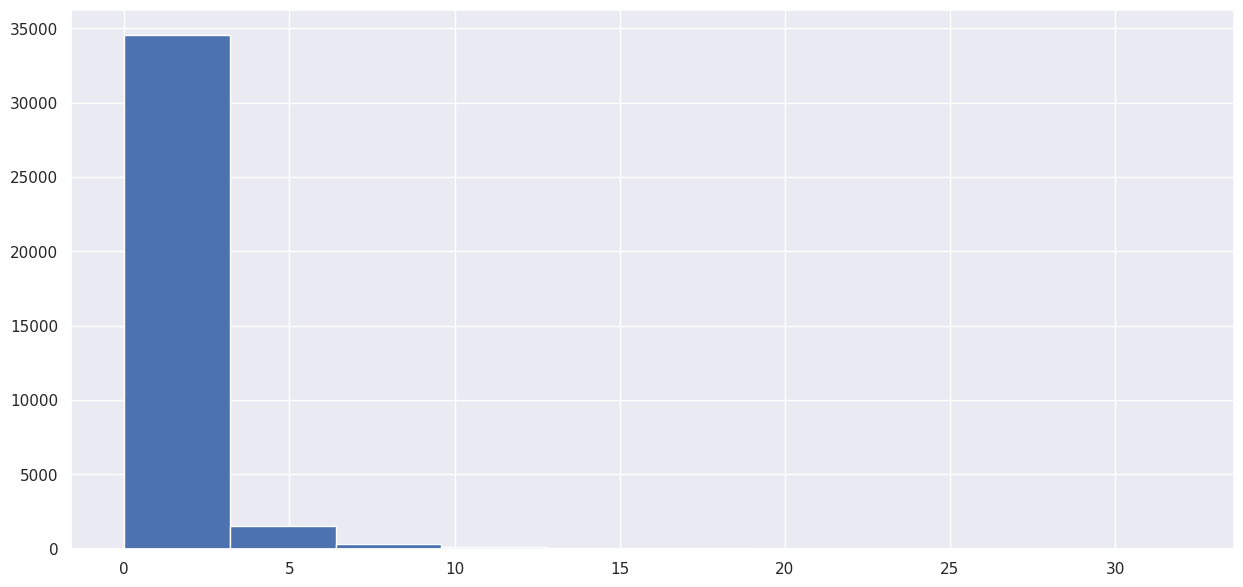

In [ ]:
spell_checker = SpellChecker(distance=1)
custom_words = ['dont', 'shouldnt', 'doesnt', 'didnt', 'isnt', 'theyre', 'youre', 'wasnt', 'b', 'c', 'f', 's', '3d','landform', 'cydonia', 'nondemocratic', 'dr', 'thier']
for word in custom_words:
    spell.word_frequency.load_words([word])

def get_num_spelling_mistakes(text, spell_checker):
    words = text.translate(str.maketrans('', '', string.punctuation)).split()
    misspelled = spell.unknown(words)
    return len(misspelled)

data['n_spelling_mistakes'] = data['discourse_text'].apply(lambda text: get_num_spelling_mistakes(text, spell_checker=spell_checker))
data['n_spelling_mistakes'].hist()

Распределение по количеству ошибок выглядит малоинформативно, а также скорее всего будет коррелировать с количеством слов. Возможно, будет полезнее упростить все до наличия/отсутсвия ошибок в тексте.

In [ ]:
data['spelling_mistakes'] = data['n_spelling_mistakes'].apply(lambda num: False if num==0 else True)

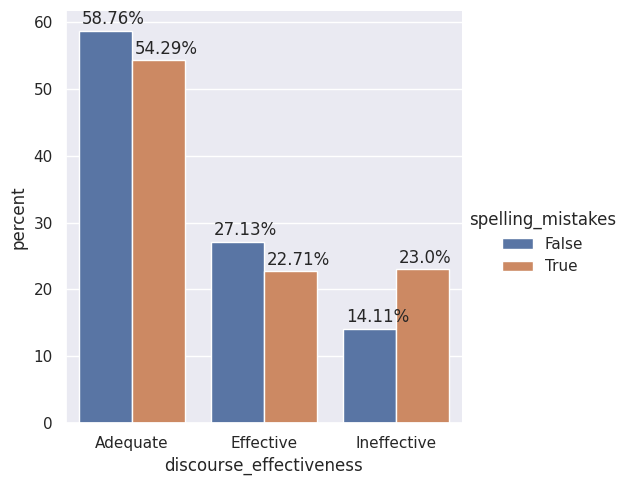

In [ ]:
x, y = 'discourse_effectiveness', 'spelling_mistakes'
fig = (data.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

for p in fig.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    fig.ax.text(txt_x + 0.02, txt_y + 1, txt)

Можно сказать, что наличие ошибок в тексте способствует присвоению класса 'Inefffective'.

## Correlation matrix

In [ ]:
label_mapping = {'Effective': 2, 'Adequate': 1, 'Ineffective': 0}
data['discourse_effectiveness_map'] = data['discourse_effectiveness'].map(label_mapping)

label_mapping_2 = {'Claim': 6, 'Concluding Statement': 5, 'Counterclaim': 4, 'Evidence': 3, 'Lead': 2, 'Position': 1, 'Rebuttal': 0}
data['discourse_type_map'] = data['discourse_type'].map(label_mapping_2)

In [ ]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,char_length,word_count,avg_word_length,n_spelling_mistakes,spelling_mistakes,discourse_effectiveness_map,discourse_type_map
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,67,4.731343,0,False,1,2
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,41,5.121951,0,False,1,1
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,21,5.000000,1,True,1,6
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,362,72,5.027778,0,False,1,3
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,101,18,5.611111,1,True,1,4


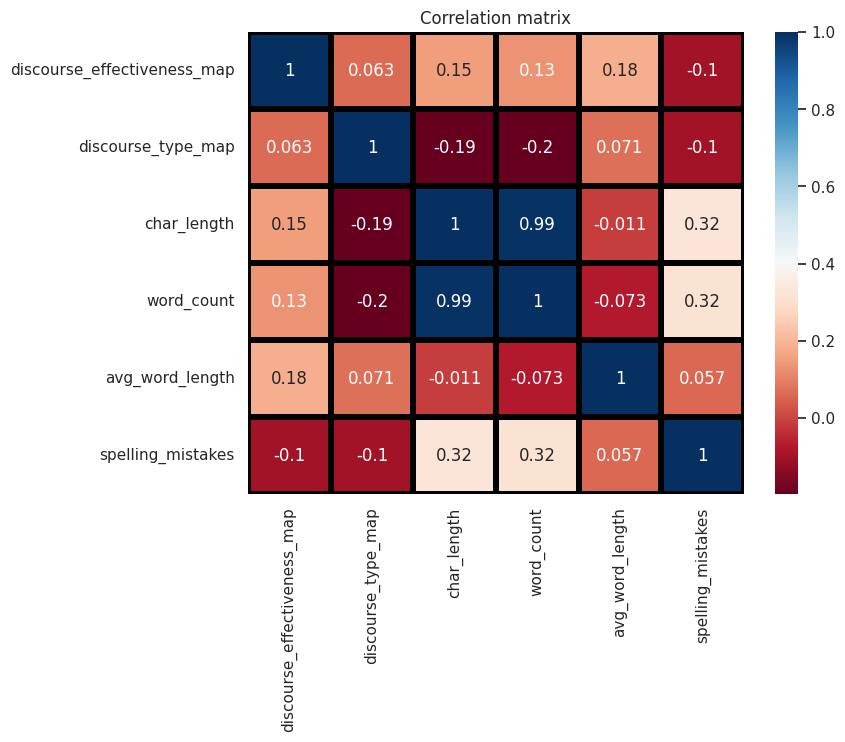

In [ ]:
correlation_matrix = data[['discourse_effectiveness_map', 'discourse_type_map', 'char_length', 'word_count', 'avg_word_length', 'spelling_mistakes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', linewidths=3, linecolor='black')
plt.title('Correlation matrix')
plt.show()

К сожалению, сильных корреляций между новыми признаками и таргетом не оказалось.